# TASK 1

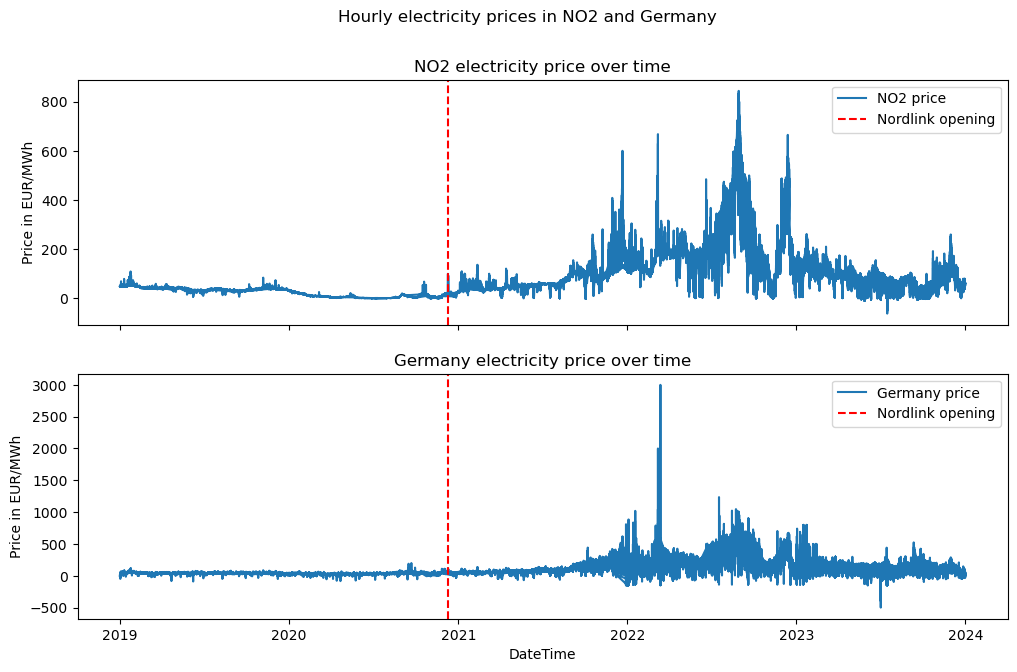

In [ ]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

# Define the data path
data_path = "C:/Users/Einar/TECH2/DATA/data/data"

# Load electricity prices dataset
price_files = glob(os.path.join(data_path, "DayAheadPrices_12.1.D", "*.csv"))
prices = pd.concat([pd.read_csv(file, delimiter="\t") for file in price_files], ignore_index=True)

# Load physical flows dataset
flow_files = glob(os.path.join(data_path, "PhysicalFlows_12.1.G", "*.csv"))
flows = pd.concat([pd.read_csv(file, delimiter="\t") for file in flow_files], ignore_index=True)

# Convert "DateTime"
prices["DateTime"] = pd.to_datetime(prices["DateTime"])

# Filter the NO2 and German region
prices_no2 = prices[prices["MapCode"] == "NO2"]
prices_de = prices[prices["MapCode"] == "DE_LU"]

# Adding the opening of nordlink as a date for future reference
opening_nordlink = pd.to_datetime("2020-12-09")

# Create axes for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
fig.suptitle("Hourly electricity prices in NO2 and Germany")

# Price Plot for NO2
ax1.plot(prices_no2["DateTime"], prices_no2["Price"], label="NO2 price")
ax1.axvline(opening_nordlink, color="r", linestyle="--", label="Nordlink opening")
ax1.set_title("NO2 electricity price over time")
ax1.set_ylabel("Price in EUR/MWh")
ax1.legend()

# Price plot for Germany
ax2.plot(prices_de["DateTime"], prices_de["Price"], label="Germany price")
ax2.axvline(opening_nordlink, color="r", linestyle='--', label="Nordlink opening")
ax2.set_title("Germany electricity price over time")
ax2.set_ylabel("Price in EUR/MWh")
ax2.set_xlabel("DateTime")
ax2.legend()

# Save the figure
plt.savefig("figure_task1.png")  # Saved locally in the current directory
plt.show()






Conclusion: Electricity prices in Norway and Germany has become much more volatile with time, especially in 2022 and early 2023. After the opening of the Nordlink, we're also seeing a trend of higher prices. The negative electricity price in mid 2023 may show that there was too much supply for the level of demand at the time. This can be explained with lowered seasonal demand in the summer as well as high energy production due to for example more sunlight, surges of wind, high rainfall or snowmelt etc. 

# TASK 2

In [ ]:
# Ensure 'DateTime' is in datetime format and add a 'Year' column for grouping
prices["DateTime"] = pd.to_datetime(prices["DateTime"])
prices["Year"] = prices["DateTime"].dt.year

# Filter for NO2 and DE_LU regions
prices_no2 = prices[prices["MapCode"] == "NO2"]
prices_de = prices[prices["MapCode"] == "DE_LU"]

# Define a function to calculate descriptive statistics
def descriptive_stats(df):
    return df.agg(["mean", "median", "std", "min", "max"]).round(2)

# Calculate statistics for each year for NO2
no2_stats = prices_no2.groupby("Year")["Price"].apply(descriptive_stats).unstack()

# Calculate statistics for each year for DE_LU
de_stats = prices_de.groupby("Year")["Price"].apply(descriptive_stats).unstack()

# Combine the two DataFrames for easier comparison
combined_stats = pd.concat([no2_stats, de_stats], axis=1, keys=["NO2", "DE_LU"])

# Save the results to an Excel file
combined_stats.to_excel("table_task2.xlsx")

combined_stats


NO2                                  DE_LU                          \
        mean  median     std    min     max    mean  median     std     min   
Year                                                                          
2019   39.26   38.81    8.23   5.86  109.45   37.67   38.06   15.52  -90.01   
2020    9.29    6.95    8.26  -1.73   99.92   30.47   30.99   17.50  -83.94   
2021   75.11   59.34   47.22  -1.97  600.16  130.41   90.44  104.80 -149.99   
2022  211.28  181.13  125.85   0.04  844.00  237.10  208.54  148.24 -149.99   
2023   79.44   80.46   36.28 -61.84  261.85   95.07   95.90   59.16 -500.00   

               
          max  
Year           
2019   121.46  
2020   200.04  
2021   809.50  
2022  2999.99  
2023   800.00

Conclusion: The standard deviation shows us increased price volatility, especially in the years 2021-2023, and spiking in 2022. Average prices has increased by more than 100% from 2019-2023. Germany has bigger fluctuations in the electricity price compared to Norway.

# TASK 3

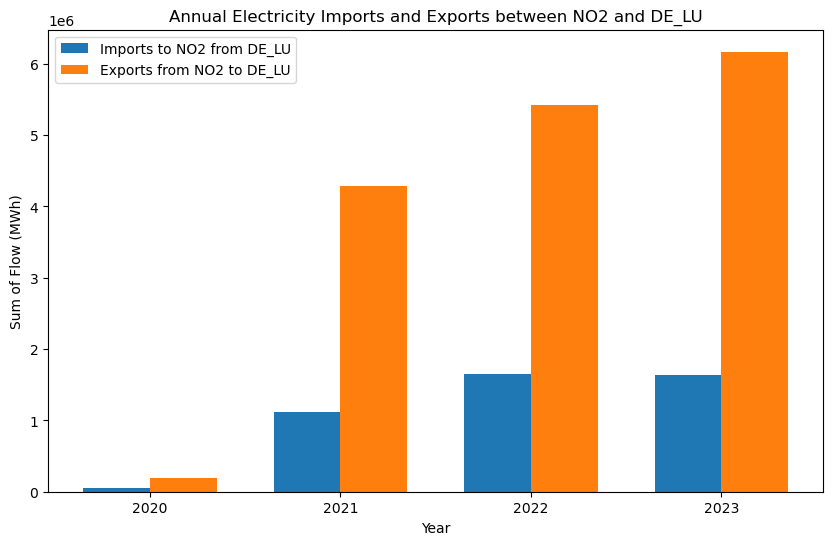

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'DateTime' is in datetime format and add a 'Year' column
flows['DateTime'] = pd.to_datetime(flows['DateTime'])
flows['Year'] = flows['DateTime'].dt.year

# Filter data for imports to NO2 from DE_LU and exports from NO2 to DE_LU
imports_to_no2 = flows[(flows['InMapCode'] == 'NO2') & (flows['OutMapCode'] == 'DE_LU')]
exports_from_no2 = flows[(flows['OutMapCode'] == 'NO2') & (flows['InMapCode'] == 'DE_LU')]

# Calculate annual sums of imports and exports specifically for DE_LU and NO2
annual_imports = imports_to_no2.groupby('Year')['FlowValue'].sum()
annual_exports = exports_from_no2.groupby('Year')['FlowValue'].sum()

# Create a bar plot showing annual sums of imports and exports
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35  # Width of the bars

# Plot imports and exports side-by-side for each year
ax.bar(annual_imports.index - width/2, annual_imports, width=width, label='Imports to NO2 from DE_LU')
ax.bar(annual_exports.index + width/2, annual_exports, width=width, label='Exports from NO2 to DE_LU')

# Add labels, title, and legend
ax.set_title('Annual Electricity Imports and Exports between NO2 and DE_LU')
ax.set_xlabel('Year')
ax.set_ylabel('Sum of Flow (MWh)')
ax.legend()

# Set x-axis to display only whole numbers (years)
ax.set_xticks(annual_imports.index)  # Ensures only whole years are shown

# Save the figure
plt.savefig('figure_task3.png')
plt.show()

# TASK 4

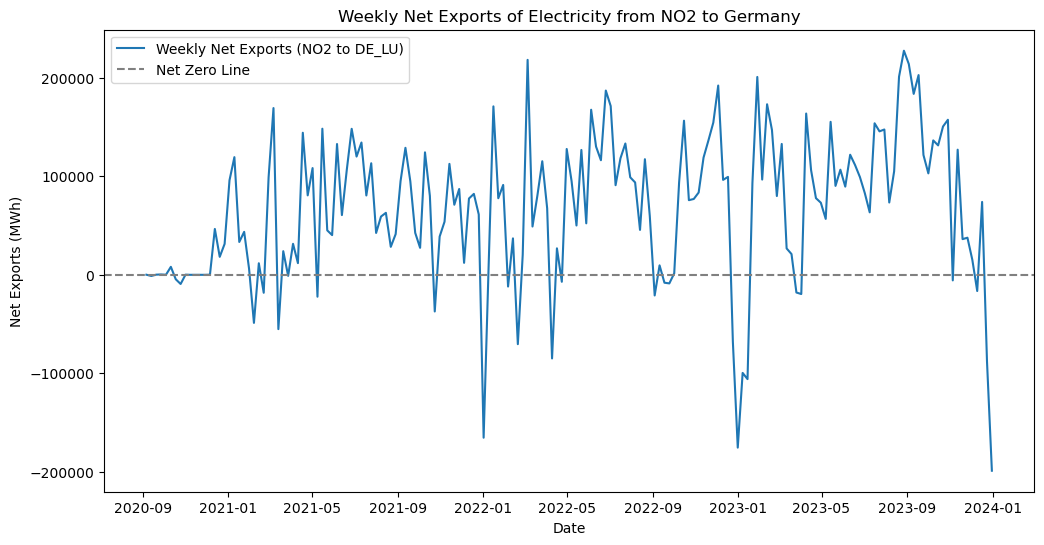

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'DateTime' is in datetime format
flows["DateTime"] = pd.to_datetime(flows["DateTime"])

# Filter exports from NO2 to DE_LU and imports to NO2 from DE_LU
exports_from_no2_to_de = flows[(flows["OutMapCode"] == "NO2") & (flows["InMapCode"] == "DE_LU")]
imports_to_no2_from_de = flows[(flows["InMapCode"] == "NO2") & (flows["OutMapCode"] == "DE_LU")]

# Set 'DateTime' as the index for easier resampling
exports_from_no2_to_de.set_index("DateTime", inplace=True)
imports_to_no2_from_de.set_index("DateTime", inplace=True)

# Resample to weekly sums of exports and imports
weekly_exports = exports_from_no2_to_de["FlowValue"].resample("W").sum()
weekly_imports = imports_to_no2_from_de["FlowValue"].resample("W").sum()

# Calculate weekly net exports (exports - imports)
weekly_net_exports = weekly_exports - weekly_imports

# Create the line plot for weekly net exports
plt.figure(figsize=(12, 6))
plt.plot(weekly_net_exports.index, weekly_net_exports, label="Weekly Net Exports (NO2 to DE_LU)")
plt.axhline(0, color="gray", linestyle="--", label="Net Zero Line")
plt.title("Weekly Net Exports of Electricity from NO2 to Germany")
plt.xlabel("Date")
plt.ylabel("Net Exports (MWh)")
plt.legend()

# Save the figure as required
plt.savefig("figure_task4.png")
plt.show()

Conclusion: The graph shows that Norway is mainly a net exporter of electricity. Generally, January is a month where we import a lot of electricity, possibly due to increased demand and decreased supply. 

# TASK 5

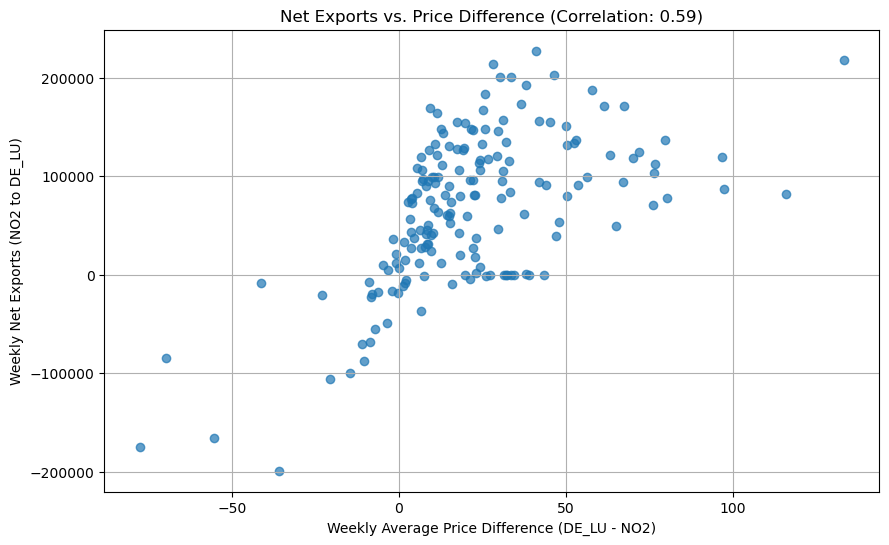

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Define paths to data
data_path = "C:/Users/Einar/TECH2/DATA/data/data"
prices_folder = os.path.join(data_path, 'DayAheadPrices_12.1.D')
flows_folder = os.path.join(data_path, 'PhysicalFlows_12.1.G')

# Load electricity price data for NO2 and DE_LU, filter for hourly prices
price_files = glob(os.path.join(prices_folder, '*.csv'))
price_data = pd.concat([
    pd.read_csv(file, sep='\t').query("MapCode in ['NO2', 'DE_LU'] and ResolutionCode == 'PT60M'")
    [['DateTime', 'MapCode', 'Price']]
    for file in price_files
])
price_data['DateTime'] = pd.to_datetime(price_data['DateTime'])

# Pivot to create separate columns for NO2 and DE_LU prices, calculate hourly price difference
prices = price_data.pivot(index='DateTime', columns='MapCode', values='Price').dropna()
prices['Price_Diff'] = prices['DE_LU'] - prices['NO2']

# Resample to get weekly average price difference
weekly_price_diff = prices['Price_Diff'].resample('W').mean()

# Load electricity flow data between NO2 and DE_LU
flow_files = glob(os.path.join(flows_folder, '*.csv'))
flow_data = pd.concat([
    pd.read_csv(file, sep='\t').query("(InMapCode == 'NO2' and OutMapCode == 'DE_LU') or (InMapCode == 'DE_LU' and OutMapCode == 'NO2')")
    [['DateTime', 'InMapCode', 'OutMapCode', 'FlowValue']]
    for file in flow_files
])
flow_data['DateTime'] = pd.to_datetime(flow_data['DateTime'])

# Calculate net exports, resample to get weekly sum of net exports
flow_data['Net_Export'] = flow_data.apply(lambda x: x['FlowValue'] if x['OutMapCode'] == 'NO2' else -x['FlowValue'], axis=1)
weekly_net_exports = flow_data.set_index('DateTime')['Net_Export'].resample('W').sum()

# Align both weekly series, calculate correlation, and plot
weekly_data = pd.DataFrame({
    'WeeklyNetExports': weekly_net_exports,
    'WeeklyAvgPriceDiff': weekly_price_diff
}).dropna()

# Calculate correlation and plot
correlation = weekly_data['WeeklyNetExports'].corr(weekly_data['WeeklyAvgPriceDiff'])
plt.figure(figsize=(10, 6))
plt.scatter(weekly_data['WeeklyAvgPriceDiff'], weekly_data['WeeklyNetExports'], alpha=0.7)
plt.xlabel("Weekly Average Price Difference (DE_LU - NO2)")
plt.ylabel("Weekly Net Exports (NO2 to DE_LU)")
plt.title(f"Net Exports vs. Price Difference (Correlation: {correlation:.2f})")
plt.grid(True)
plt.savefig('figure_task5.png')
plt.show()

# TASK 6

ASDJK